In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D  
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(channel_func, channel_pars, channel_args, dm_ini, pars, n_layers, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_n = []
    dms_n_p = []
    dms_n_m = []
    for p in channel_pars:
        dm_n = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_n_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_n_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dms_n.append(dm_n)
        dms_n_p.append(dm_n_p)
        dms_n_m.append(dm_n_m)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(channel_pars)): # take a density matrix from the training set
        probs = [trace(dms_n[j]@proj).real for proj in projs_u]
        probs_der = [trace((dms_n_p[j] - dms_n_m[j])@proj).real/(2*dp) for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        QFI = 2*(1 - sqrt(fidelity(dms_n_m[j], dms_n_p[j]))) / dp**2 + 1e-10 # via centered differences 
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
        QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [3]:
def H_min(k, a=0.0, b=1.0):
    return 1/2*(h0(k,a,b)*I + h1(k,a,b)*X + h3(k,a,b)*Z)

def h0(k, a, b):
    L = b - a
    c1 = (2/3)*((1 - a)**(3/2) - (1 - b)**(3/2))
    c2 = (1/2)*(b**2 - a**2)
    c3 = (2/5)*((1 - b)**(5/2) - (1 - a)**(5/2))
    c4 = (1/3)*(b**3 - a**3)
    numerator = (2*c2*((c1 + c3)**2 + c2*c4)*(k - 1) - 2*(c2**2 * (k - 1) + c1*(c1 + c3)*k + c2*c4*k)*L + 2*c2 * k * L**2)
    denominator = ((c2**3 + 2 * c1*c2*c3 + c1**2*(2*c2 - c4)) * (k - 1)*k - ((c1 + c3)**2 + c2*c4 - (c1**2 + 4*c1*c3 + 2*(c3**2 + c2*c4))*k + ((c1 + c3)**2 + c2*(c2 + c4))*k**2)*L + (k - 1)*(-c2 + c4*k)*L**2 + k*L**3)
    h0_expr = numerator / denominator
    return h0_expr

def h1(k, a, b):
    L = b - a
    c1 = (2/3)*((1 - a)**(3/2) - (1 - b)**(3/2))
    c2 = (1/2)*(b**2 - a**2)
    c3 = (2/5)*((1 - b)**(5/2) - (1 - a)**(5/2))
    c4 = (1/3)*(b**3 - a**3)
    numerator = (2 * k * (c2 * (-c2 * (c1 + c3) + c1 * c4) 
                          - c1 * c2 * L + (c1 + c3) * L**2))
    denominator = ((c2**3 + 2 * c1 * c2 * c3 + c1**2 * (2 * c2 - c4)) * (-1 + k) * k 
                   - ((c1 + c3)**2 + c2 * c4 
                      - (c1**2 + 4 * c1 * c3 + 2 * (c3**2 + c2 * c4)) * k 
                      + ((c1 + c3)**2 + c2 * (c2 + c4)) * k**2) * L 
                   + (-1 + k) * (-c2 + c4 * k) * L**2 
                   + k * L**3)
    h1_expr = numerator / denominator
    return h1_expr

def h3(k, a, b):
    # Define L and the ci variables
    L = b - a
    c1 = (2/3) * ((1 - a)**(3/2) - (1 - b)**(3/2))
    c2 = (1/2) * (b**2 - a**2)
    c3 = (2/5) * ((1 - b)**(5/2) - (1 - a)**(5/2))
    c4 = (1/3) * (b**3 - a**3)
    numerator = (2 * k * (c2**3 * (-1 + k) 
                          + (c3**2 + c2 * c4 - (c3**2 + c2 * (c2 + c4)) * k) * L 
                          + c4 * k * L**2 
                          + c1 * c3 * (c2 * (-1 + 2 * k) - 2 * (-1 + k) * L) 
                          + c1**2 * (c2 * (-1 + 2 * k) + L - k * (c4 + L))))
    denominator = ((c2**3 + 2 * c1 * c2 * c3 + c1**2 * (2 * c2 - c4)) * (-1 + k) * k 
                   - ((c1 + c3)**2 + c2 * c4 
                      - (c1**2 + 4 * c1 * c3 + 2 * (c3**2 + c2 * c4)) * k 
                      + ((c1 + c3)**2 + c2 * (c2 + c4)) * k**2) * L 
                   + (-1 + k) * (-c2 + c4 * k) * L**2 
                   + k * L**3)
    h3_expr = numerator / denominator
    return h3_expr


def rho_a(alpha):
    return (I + sqrt(1 - alpha)*X + alpha*Z)/2
    
def expec_der_theor(k, alpha, a=0.0, b=1.0):
    d_rho=np.array([[1/2, -1/(4*sqrt(1 - alpha))], 
                    [-1/(4*sqrt(1 - alpha)), -1/2]])
    return trace(d_rho@H_min(k, a, b))
    
def expec_H(k, alpha, a=0.0, b=1.0):
    return trace(rho_a(alpha)@H_min(k, a, b)).real
    
def disp_H(k, alpha, a=0.0, b=1.0):
    dm = rho_a(alpha)
    H = H_min(k, a, b)
    return trace(dm@H@H).real - trace(dm@H).real**2 #+k*((trace(rho_a(alpha)@H_min(k, a, b))-alpha)**2)

In [4]:
channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
dm_ini = (eye(2) + X)/2

a = 1e-3
b = 1 - 1e-3
T = 500
V = 21

labels_train = linspace(a, b, T)
labels_test = linspace(a, b, V)

dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

In [5]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1
dp = 1e-5
x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

In [6]:
expecs_test_list = []
expecs_theor_list = []
expecs_der_test_list = []
expecs_der_theor_list = []
disps_test_list = []
disps_theor_list = []
CFIs_test_list = []

w_ls = 1
# w_var_list = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
w_var_list = [1e0, 1e-2, 1e-4]

for w_var in w_var_list:
    fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
               w_ls=w_ls, w_var=w_var, x0=x0, options={})
    pars = result.x
    
    print("_______________________________________________________________________________")
    print("\n", result.message)
    expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, 
                                                                      channel_args, dm_ini, pars, n_layers,
                                                                      n_copies=n_copies, n_meas=n_meas, dp=dp)
    k = w_ls/w_var
    expecs_theor  = array([expec_H(k, alpha, a, b) for alpha in linspace(a, b, V)])
    disps_theor = array([disp_H(k, alpha, a, b) for alpha in linspace(a, b, V)])
    expecs_der_theor = array([expec_der_theor(k, alpha, a=a,b=b) for alpha in linspace(a, b, V)])

    print("Cost:", result.fun)
    print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
    print("w_ls: %f | w_var: %f " %(w_ls, w_var))
    print("\nSum error:", sum(np.abs(labels_test - expecs_test)**2)/len(CFIs_test))
    print("Sum var:", n_copies*sum(disps_test/expecs_der_test**2)/len(CFIs_test))
    
    expecs_test_list.append(expecs_test)
    expecs_theor_list.append(expecs_theor)
    expecs_der_test_list.append(expecs_der_test)
    expecs_der_theor_list.append(expecs_der_theor)    
    disps_test_list.append(disps_test)
    disps_theor_list.append(disps_theor)
    CFIs_test_list.append(CFIs_test)

_______________________________________________________________________________

 Optimization terminated successfully.
Cost: 35.95966497736153

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 1.000000 

Sum error: 0.06769306833867013
Sum var: 0.5173166080843843
_______________________________________________________________________________

 Optimization terminated successfully.
Cost: 2.6595881380959643

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.010000 

Sum error: 0.0007442756684675245
Sum var: 0.5446934873225759
_______________________________________________________________________________

 Optimization terminated successfully.
Cost: 0.03315032148906329

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 5.718500838546322e-07
Sum var: 0.6539849680231382


In [7]:
### taken from channels-bayes.ipynb ###

expecs_bayes = array([0.43678082, 0.44252656, 0.448321  , 0.45416826, 0.46007306,
       0.46604089, 0.47207815, 0.47819242, 0.48439276, 0.49069017,
       0.49709819, 0.50363386, 0.5103191 , 0.51718293, 0.52426514,
       0.531623  , 0.53934427, 0.5475763 , 0.55660536, 0.5671644 ,
       0.58510321])

expecs_der_bayes = array([0.11468201, 0.11562029, 0.11663562, 0.11773918, 0.11894451,
       0.12026829, 0.12173129, 0.12335975, 0.12518743, 0.12725855,
       0.12963244, 0.13239089, 0.13565037, 0.13958357, 0.14445997,
       0.15072895, 0.15921101, 0.1716156 , 0.19234817, 0.23870199,
       1.22129903])

disps_bayes = array([0.00618301, 0.00697922, 0.00771531, 0.00839004, 0.00900201,
       0.00954966, 0.0100312 , 0.01044459, 0.01078744, 0.01105696,
       0.01124979, 0.01136187, 0.01138813, 0.0113221 , 0.01115519,
       0.01087554, 0.01046565, 0.00989731, 0.0091181 , 0.00800001,
       0.00558928])

In [8]:
path = r"/home/kardashin/Work/QPE/Results/Channels/"
info = "ad_chan-bayes"
path + info

'/home/kardashin/Work/QPE/Results/Channels/ad_chan-bayes'

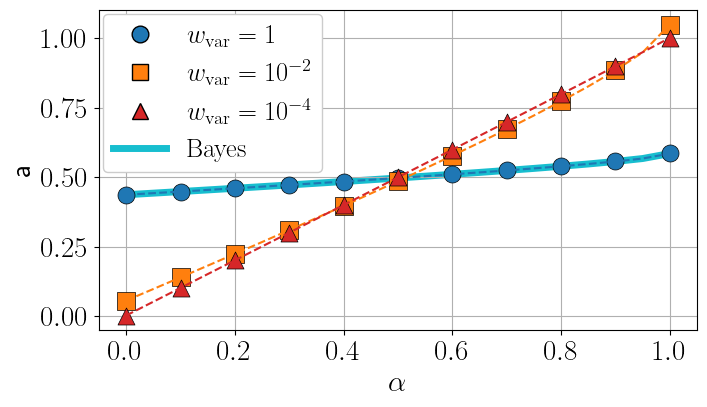

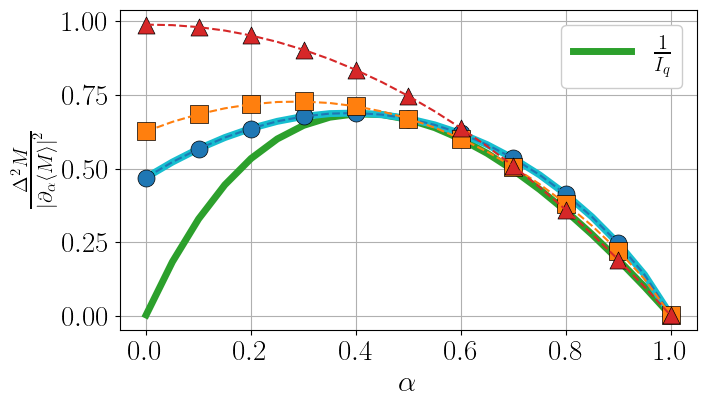

In [9]:
matplotlib.rcParams.update({'font.size': 21})

markers = ["o", "s", "^", "d"]
colors = ["C0", "C1", "C3", "C2",]

plt.figure(figsize=(7.5, 4.5))
# plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
for w in range(len(w_var_list)):
    plt.scatter(labels_test[::2], expecs_test_list[w][::2], s=150, zorder=w+10, color=colors[w], marker=markers[w], ec="black", linewidth=0.5) # , label=r"$w_\mathrm{var} = 10^{%d}$" %int(np.log10(w_var_list[w]))
    # plt.scatter(labels_test, expecs_theor_list[w], s=80, zorder=w+10, color=colors[w], marker="X", ec="black", linewidth=0.5)
    plt.plot(labels_test, expecs_theor_list[w], zorder=w+10, color=colors[w], linestyle="--", linewidth=1.5)
plt.plot(labels_test, expecs_bayes, color="tab:cyan", linewidth=5, zorder=1) # , label="Bayes"
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
##
# lines = [Line2D([0], [0], color=colors[w], marker=markers[w], linewidth=0, markersize=12, markeredgecolor="black") for w in range(len(w_var_list))] + [Line2D([0], [0], color=colors[0])] + [Line2D([0], [0], color="white", marker="X", linewidth=0, markersize=12, markeredgecolor="black")]
lines = [Line2D([0], [0], color=colors[w], marker=markers[w], linewidth=0, markersize=12, markeredgecolor="black") for w in range(len(w_var_list))] + [Line2D([0], [0], color="tab:cyan", linewidth=5)] + [Line2D([0], [0], color="black", linewidth=1.5, linestyle="--")]
labels = [r"$w_\mathrm{var} = 1$"] + [r"$w_\mathrm{var} = 10^{%d}$" %int(np.log10(w_var_list[w])) for w in range(1, len(w_var_list))] + ["Bayes"]#, "Analytical"]
plt.legend(lines, labels, framealpha=1, ncol=1, fontsize=19, bbox_to_anchor=(0.19, 0.74), loc="center")#, bbox_to_anchor=(0.19, 0.595), loc="center") # (0.375, 0.8)
##
# plt.legend(ncol=1, framealpha=1)
plt.grid(zorder=0)
plt.tight_layout()
plt.savefig(path + info + "-expec.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7.5, 4.5))
for w in range(len(w_var_list)):    
    plt.scatter(labels_test[::2], n_copies*disps_test_list[w][::2]/expecs_der_test_list[w][::2]**2, s=150, zorder=10, color=colors[w], ec="black", linewidth=0.5, marker=markers[w])
    # plt.scatter(labels_test, n_copies*disps_theor_list[w]/expecs_der_theor_list[w]**2, s=80, zorder=10, color=colors[w], ec="black", linewidth=0.5, marker="X")
    plt.plot(labels_test, n_copies*disps_theor_list[w]/expecs_der_theor_list[w]**2, zorder=10, linestyle="dashed", color=colors[w], linewidth=1.5)
    # plt.plot(labels_test, n_copies/CFIs_test_list[w], color=colors[w], linewidth=1.5, linestyle="dashed") # , color="tab:red" , label=r"$\frac{1}{I_c}:\quad\omega_{var} = %.4f$"%(w_var_list[w])
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color=colors[-1], linewidth=5, linestyle="solid", label=r"$\frac{1}{I_q}$") # , color="tab:blue"
plt.plot(np.sort(labels_test), disps_bayes/expecs_der_bayes**2, linewidth=5, color="tab:cyan")
plt.ylabel(r"$\frac{\Delta^2 M}{\left|\partial_\alpha \langle M \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")

plt.legend(framealpha=1)

plt.grid(zorder=0)
plt.tight_layout()
# plt.savefig(path + info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()